In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [3]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report,cohen_kappa_score
from keras.layers import GaussianNoise
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...


Using TensorFlow backend.


Librairies imported


In [4]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
df_15min = pd.read_csv('20190526 data prepared.csv')
df_15min = df_15min.iloc[:,1:]
df_15min = df_15min.dropna()
df_15min.reset_index(inplace=True,drop=True)

In [6]:
df_15min.isnull().sum().sum()

0

In [7]:
df_15min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6441 entries, 0 to 6440
Data columns (total 21 columns):
Date                  6441 non-null object
Varop_Spy             6441 non-null float64
Varhl_spy             6441 non-null float64
RSI                   6441 non-null float64
75 - RSI              6441 non-null float64
RSI - 25              6441 non-null float64
BBD_Delta_Up          6441 non-null float64
delta5_8              6441 non-null float64
delta8_10             6441 non-null float64
delta10_12            6441 non-null float64
delta12_15            6441 non-null float64
delta15_30            6441 non-null float64
delta30_35            6441 non-null float64
delta35_40            6441 non-null float64
delta40_45            6441 non-null float64
delta45_50            6441 non-null float64
delta_tsf             6441 non-null float64
Forcast Oscillator    6441 non-null float64
target_up             6441 non-null int64
target_down           6441 non-null int64
target_value      

plt.figure(figsize=(26,20))
sns.heatmap(df_15min.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [8]:
df_15min.shape

(6441, 21)

In [9]:
df_15min['target_up'].sum(),df_15min['target_down'].sum(),len(df_15min)

(59, 59, 6441)

In [10]:
#df_15min = df_15min.iloc[-2500:,:]
#df_15min['target_up'].sum(),df_15min['target_down'].sum()

In [11]:
delta = round(df_15min.shape[0])
bloc1 = round(delta*0.9)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_15min.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_15min.iloc[bloc2,0],')')
print('First period :',df_15min.iloc[0,0])
print('Last period :',df_15min.iloc[df_15min.shape[0]-1,0])


# of periods :  6441
On 80% - 20% slash : 
Bloc 1 :  5797  periods ( 20190426  17:00:00 )
Bloc 2 : 644  periods ( 20180711  16:15:00 )
First period : 20180604  21:15:00
Last period : 20190531  21:45:00


In [12]:
X = df_15min.iloc[:,1:-3]
y_up = df_15min.iloc[:,-3].values
y_down = df_15min.iloc[:,-2].values

In [13]:
ytrain_up = y_up[:bloc1]
ytest_up = y_up[bloc1:]
ytrain_down = y_down[:bloc1]
ytest_down = y_down[bloc1:]

Xtrain_up =   X.iloc[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','delta40_45', 'delta45_50']]
Xtrain_down = X.iloc[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]
Xtest_up =   X.iloc[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','delta40_45', 'delta45_50']]
Xtest_down = X.iloc[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]

In [14]:
from collections import Counter
print('Original dataset shape_up %s' % Counter(ytrain_up))
print('Original dataset shape_down %s' % Counter(ytrain_down))

Original dataset shape_up Counter({0: 5747, 1: 50})
Original dataset shape_down Counter({0: 5747, 1: 50})


In [15]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=42,sampling_strategy='not majority') 
Xtrain_up, ytrain_up = cc.fit_resample(Xtrain_up, ytrain_up)
Xtrain_down, ytrain_down = cc.fit_resample(Xtrain_down, ytrain_down)

In [16]:
print('Resampled dataset shape %s' % Counter(ytrain_up))
print('Resampled dataset shape %s' % Counter(ytrain_down))

Resampled dataset shape Counter({0: 5747, 1: 50})
Resampled dataset shape Counter({0: 5747, 1: 50})


In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
Xtrain_up = scaler.fit_transform(Xtrain_up)
Xtest_up = scaler.fit_transform(Xtest_up)
Xtrain_down = scaler.fit_transform(Xtrain_down)
Xtest_down = scaler.fit_transform(Xtest_down)


#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [18]:
# fix random seed for reproducibility
seed = 770
np.random.seed(seed)

In [19]:
from keras.regularizers import l1,l2
# import norm
from keras.constraints import max_norm
# instantiate norm
norm = max_norm(3.0)



#ytrain_up = ytrain_up.reshape(ytrain_up.shape[0],)
#ytrain_down = ytrain_down.reshape(ytrain_down.shape[0],)

#Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1])

model_up = Sequential()
# Add an input layer 
model_up.add(Dense(50, activation='relu'))
model_up.add(Dropout(0.4))
# Add one hidden layer 
model_up.add(Dense(50, activation='relu'))
model_up.add(Dropout(0.4))
# Add an output layer 
model_up.add(Dense(1, activation='relu'))

model_down = Sequential()

# Add an input layer 
model_down.add(Dense(50, activation='relu'))
model_down.add(Dropout(0.4))
# Add one hidden layer 
model_down.add(Dense(50, activation='relu'))
model_down.add(Dropout(0.4))
# Add an output layer 
model_down.add(Dense(1, activation='relu'))

In [20]:
print('Processing move_up')
model_up.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_up = model_up.fit(Xtrain_up, ytrain_up,epochs=100, batch_size=32, verbose=0,validation_split=0.0,shuffle=True)

print('Processing move_down')
model_down.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_down = model_down.fit(Xtrain_down, ytrain_down,epochs=100, batch_size=32, verbose=0,validation_split=0.0,shuffle=True)

print('Computing done')

Processing move_up
Processing move_down
Computing done


In [21]:
yhat_up = model_up.predict_classes(Xtest_up, batch_size=1, verbose=1)
yhat_down = model_down.predict_classes(Xtest_down, batch_size=1, verbose=1)


644/644 [==============================] - 0s 302us/step


In [22]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 

# kappa
kappa_up = cohen_kappa_score(ytest_up, yhat_up)
kappa_down = cohen_kappa_score(ytest_down, yhat_down)

f1_up = (2 * (precision_up * recall_up)) / (precision_up + recall_up)
f1_down = (2 * (precision_down * recall_down)) / (precision_down + recall_down)

roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [23]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print('F1 : %.2f%%' % (f1_up * 100))
print('Cohens kappa: %f' % kappa_up)
print("ROC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 98.60%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
F1 : nan%
Cohens kappa: 0.000000
ROC: 50.00% 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       635
           1       0.00      0.00      0.00         9

   micro avg       0.99      0.99      0.99       644
   macro avg       0.49      0.50      0.50       644
weighted avg       0.97      0.99      0.98       644

[[635   0]
 [  9   0]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [24]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print('F1 : %.2f%%' % (f1_down * 100))
print('Cohens kappa: %f' % kappa_down )
print("ROC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 98.60%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
F1 : nan%
Cohens kappa: 0.000000
ROC: 50.00% 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       635
           1       0.00      0.00      0.00         9

   micro avg       0.99      0.99      0.99       644
   macro avg       0.49      0.50      0.50       644
weighted avg       0.97      0.99      0.98       644

[[635   0]
 [  9   0]]
Matrice de confusion :


,Vrais_estimés,Faux_estimés
vrais_réels,Vrais_positifs,Faux_négatif
Faux_réels,Faux_positifs,Vrais-négatifs


In [25]:
len(df_15min)-(len(df_15min)-bloc2),yhat_up.sum(),yhat_down.sum()

(644, 0, 0)

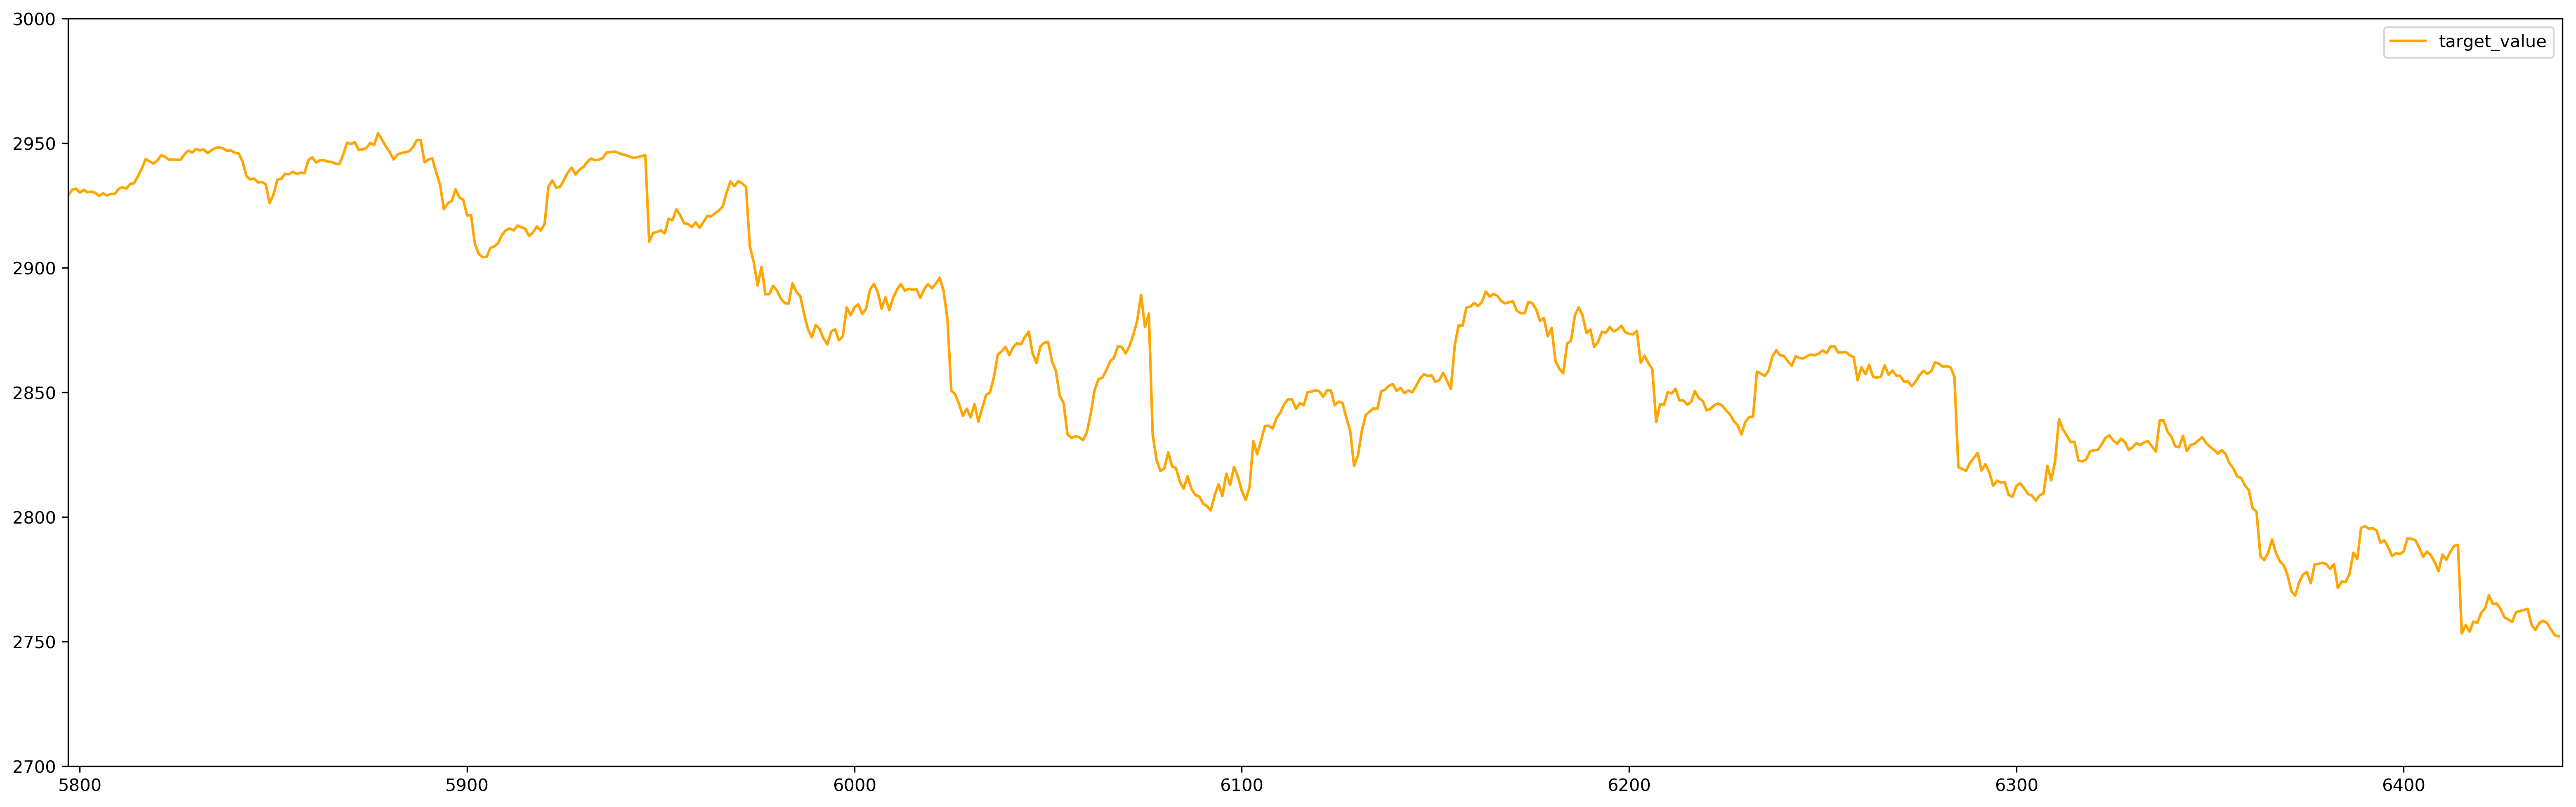

In [26]:
plt.figure(figsize=(26,8),dpi=300)
plt.xlim((len(df_15min)-bloc2,len(df_15min)))
plt.ylim((2700,3000))
plt.plot(df_15min['target_value'],color='orange')
a = -1
for i in range(len(df_15min)-bloc2,len(df_15min)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='r',marker='o')
plt.legend()

In [27]:
sum(yhat_up),sum(yhat_down)

(array([0], dtype=int32), array([0], dtype=int32))

In [28]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)